In [1]:
!pip install tf-nightly

    100% |████████████████████████████████| 105.2MB 198kB/s ta 0:00:011 9% |███                             | 9.9MB 2.1MB/s eta 0:00:46    15% |█████                           | 16.2MB 2.7MB/s eta 0:00:34    44% |██████████████▍                 | 47.2MB 972kB/s eta 0:01:00    51% |████████████████▍               | 54.0MB 2.7MB/s eta 0:00:20
    100% |████████████████████████████████| 3.1MB 1.3MB/s ta 0:00:011
  Using cached https://files.pythonhosted.org/packages/da/3f/9b0355080b81b15ba6a9ffcf1f5ea39e307a2778b2f2dc8694724e8abd5b/absl-py-0.7.1.tar.gz
    100% |████████████████████████████████| 61kB 9.1MB/s eta 0:00:01
    100% |████████████████████████████████| 491kB 1.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for absl-py ... done
  Stored in directory: /Users/akshaybrijpuria/Library/Caches/pip/wheels/ee/98/38/46cbcc5a93cfea5492d19c38562691ddb23b940176c14f7b48
Successfully built absl-py
  Found existing installation: absl-py 0.6.1
    Uninstalling absl-py-0.6.1:
      Successfully

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()

In [2]:
tf.executing_eagerly()

True

In [3]:
dftrain = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_eval.csv')
y_train = dftrain.pop('survived')
yeval = dfeval.pop('survived')

In [4]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [5]:
dftrain.columns

Index(['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck',
       'embark_town', 'alone'],
      dtype='object')

In [6]:
dftrain.age.hist(bins=20);

In [7]:
dftrain.shape[0],dfeval.shape[0]

(627, 264)

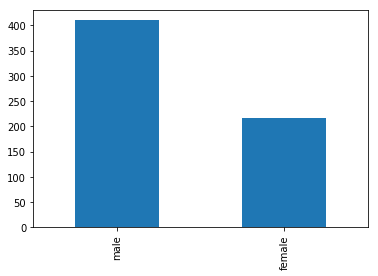

In [8]:
dftrain.sex.value_counts().plot(kind='bar')

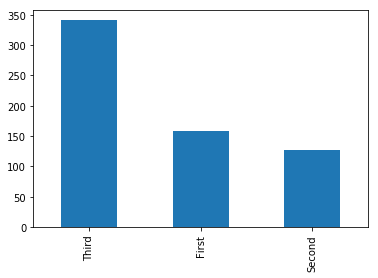

In [9]:
dftrain['class'].value_counts().plot(kind='bar')

Text(0, 0.5, '% survived')

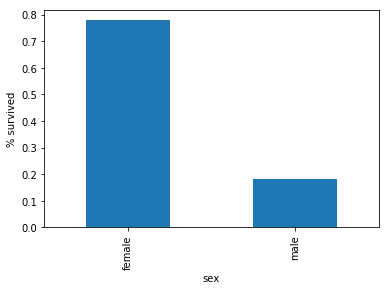

In [10]:
az = pd.concat([dftrain,y_train], axis=1).groupby('sex').survived.mean().plot(kind='bar')
az.set_ylabel('% survived')

In [11]:
from tensorflow import feature_column

In [12]:
fc = feature_column

In [13]:
features = dftrain.columns

In [14]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

ft_col = []

for vc in CATEGORICAL_COLUMNS:
    vocab = dftrain[vc].unique()
    ft_col.append(fc.indicator_column(fc.categorical_column_with_vocabulary_list(vc,vocab)))

for nc in NUMERIC_COLUMNS:
    ft_col.append(fc.numeric_column(nc,dtype=tf.float32))

In [15]:
NUM_EXAMPLE = len(dftrain)

def make_input_fn(X,Y,n_epoch=None,shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X),Y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLE)
        dataset = dataset.repeat(n_epoch)
        dataset = dataset.batch(NUM_EXAMPLE)
        return dataset
    return input_fn

train_dataset = make_input_fn(dftrain,y_train)
eval_dataset = make_input_fn(dfeval,yeval,n_epoch=1,shuffle=True)

In [16]:
classifier = tf.estimator.LinearClassifier(ft_col)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/6v/4p9b28qd1s9ckw__97m6_v3m0000gn/T/tmp4kyt3p4u', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12894e240>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [22]:
classifier.train(train_dataset,max_steps=1000)
classifier.evaluate(eval_dataset)

INFO:tensorflow:Skipping training since max_steps has already saved.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-01T12:49:24Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/6v/4p9b28qd1s9ckw__97m6_v3m0000gn/T/tmp4kyt3p4u/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-01-12:49:25
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.7878788, accuracy_baseline = 0.625, auc = 0.8377104, auc_precision_recall = 0.781876, average_loss = 0.46705678, global_step = 1000, label/mean = 0.375, loss = 123.30299, precision = 0.7128713, prediction/mean = 0.3935513, recall = 0.72727275
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /var/folders/6v/4p9b28qd1s9ckw__97m6_v3m0000g

{'accuracy': 0.7878788,
 'accuracy_baseline': 0.625,
 'auc': 0.8377104,
 'auc_precision_recall': 0.781876,
 'average_loss': 0.46705678,
 'label/mean': 0.375,
 'loss': 123.30299,
 'precision': 0.7128713,
 'prediction/mean': 0.3935513,
 'recall': 0.72727275,
 'global_step': 1000}

In [31]:
cls = tf.estimator.BoostedTreesClassifier(ft_col,n_batches_per_layer=1,center_bias=True)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/6v/4p9b28qd1s9ckw__97m6_v3m0000gn/T/tmpnzdemb_r', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12acf4da0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [32]:
cls.train(train_dataset)
cls.evaluate(eval_dataset)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/6v/4p9b28qd1s9ckw__97m6_v3m0000gn/T/tmpnzdemb_r/model.ckpt.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:loss = 0.6931468, step = 0
INFO:tensorflow:global_step/sec: 82.6109
INFO:tensor

{'accuracy': 0.7878788,
 'accuracy_baseline': 0.625,
 'auc': 0.8339149,
 'auc_precision_recall': 0.8098376,
 'average_loss': 0.71266776,
 'label/mean': 0.375,
 'loss': 0.71266776,
 'precision': 0.7171717,
 'prediction/mean': 0.3839684,
 'recall': 0.7171717,
 'global_step': 603}